In [5]:
# Install required packages that may be missing in the kernel
# Using pip install here so it installs into the active kernel environment
import sys
!{sys.executable} -m pip install matplotlib tqdm --quiet
print('Installed matplotlib and tqdm')

Installed matplotlib and tqdm


In [6]:
import os
from pathlib import Path
# Use a writable data directory in the user's home folder
DATA_DIR = str(Path.home() / 'lenet_data')
print('Using DATA_DIR =', DATA_DIR)
os.makedirs(DATA_DIR, exist_ok=True)

Using DATA_DIR = C:\Users\陈奕炜\lenet_data


# 🧠 LeNet-5 Training Demo

## 📌 BEFORE YOU START:

### ✅ Enable GPU:
1. Click **Runtime** → **Change runtime type**
2. Select **GPU** under Hardware accelerator
3. Click **Save**

### 📊 What This Notebook Does:
- Builds LeNet-5 CNN from scratch
- Trains on MNIST with GPU acceleration
- Visualizes training progress
- Tests predictions on sample images
- **Visualizes intermediate feature maps**
- Evaluates model performance

## 🚀 Step 1: Check GPU Availability

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # Use standard tqdm (text mode)
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*60)
if torch.cuda.is_available():
    print("✅ GPU IS AVAILABLE!")
    print(f"📍 GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️  WARNING: GPU NOT AVAILABLE!")
    print("👉 Enable GPU: Runtime → Change runtime type → GPU")
print("="*60)
print(f"\n🎯 Using device: {device}")

✅ GPU IS AVAILABLE!
📍 GPU Device: NVIDIA GeForce RTX 2050
💾 GPU Memory: 4.29 GB

🎯 Using device: cuda


## 📦 Step 2: Load MNIST Dataset

**MNIST Dataset:**
- 60,000 training images of handwritten digits (0-9)
- 10,000 test images
- Each image is 28×28 pixels, grayscale
- One of the most popular datasets for learning computer vision

**What this cell does:**
1. Downloads MNIST dataset (first time only)
2. Applies transformations: converts to tensor and normalizes
3. Creates DataLoaders for efficient batch processing

### 🔍 Function Explanations

---

#### 1️⃣ `transforms.Compose()`
**Purpose:** Chains multiple data transformation operations together, executing them sequentially

```python
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
```

**How it works:**
- Input image → `ToTensor()` → `Normalize()` → Output processed tensor
- Like a pipeline: data flows through each transformation step in order

---

#### 2️⃣ `transforms.ToTensor()`
**Purpose:** Converts PIL Image or numpy array to PyTorch tensor

**Transformation details:**
```python
# Input:  PIL Image (28, 28), pixel values [0, 255]
# Output: Tensor shape (1, 28, 28), pixel values [0.0, 1.0]
```

**What happens:**
- Converts image from HWC (Height, Width, Channels) to CHW (Channels, Height, Width)
- Scales pixel values from [0, 255] to [0.0, 1.0] by dividing by 255
- Converts data type to `torch.FloatTensor`

**Example:**
```python
# Before: PIL Image, value = 255 (white pixel)
# After:  Tensor, value = 1.0
```
---

#### 3️⃣ `transforms.Normalize(mean, std)`
**Purpose:** Normalizes tensor with given mean and standard deviation

```python
transforms.Normalize((0.1307,), (0.3081,))
# mean = 0.1307
# std  = 0.3081
```

**Formula:**
```
output = (input - mean) / std
```

**Why normalize?**
- Centers data around 0 (mean subtraction)
- Makes training more stable and faster
- Helps gradient descent converge better
- Values for MNIST are pre-calculated from the entire dataset

**Example calculation:**
```python
# Input pixel value: 0.5
# After normalize: (0.5 - 0.1307) / 0.3081 ≈ 1.20
```

---

#### 4️⃣ `datasets.MNIST()`
**Purpose:** Downloads and loads the MNIST dataset

```python
train_dataset = datasets.MNIST(
    root='./data',       # Directory to save/load data
    train=True,          # Load training set (if False, loads test set)
    download=True,       # Download if not already present
    transform=transform  # Apply transformations to each image
)
```

**Parameters explained:**
- `root`: Local folder path where dataset will be stored
- `train`: Boolean flag
  - `True` → 60,000 training images
  - `False` → 10,000 test images
- `download`: Automatically downloads if data not found
- `transform`: Preprocessing function applied to each image when loaded

**What you get:**
```python
len(train_dataset)  # 60,000
train_dataset[0]    # Returns (image_tensor, label)
# image_tensor shape: (1, 28, 28)
# label: int from 0-9
```

---

#### 5️⃣ `DataLoader()`
**Purpose:** Creates an iterator that loads data in batches with optional shuffling and parallel loading

```python
train_loader = DataLoader(
    train_dataset,         # Dataset to load from
    batch_size=64,         # Number of samples per batch
    shuffle=True,          # Randomize order each epoch
    num_workers=2          # Number of subprocesses for data loading
)
```

**Parameters explained:**

**`batch_size=64`**
- Loads 64 images at once instead of one at a time
- Trade-off: Larger = faster training but more GPU memory
- Common values: 32, 64, 128, 256

**`shuffle=True`** (for training)
- Randomizes sample order every epoch
- Prevents model from learning order patterns
- Important for good generalization
- Set to `False` for test set (consistent evaluation)

**`num_workers=2`**
- Number of parallel processes loading data
- Speeds up data loading (CPU task)
- Values: 0 (single process), 2-4 (typical), 8+ (many cores)
- In Colab: 2 is usually good

---

#### 📊 Complete Data Flow

```
Original MNIST Image (28×28 pixels, values 0-255)
          ↓
    ToTensor()
          ↓
    Tensor (1, 28, 28), values [0.0, 1.0]
          ↓
    Normalize(mean=0.1307, std=0.3081)
          ↓
    Normalized Tensor (1, 28, 28), values centered around 0
          ↓
    DataLoader batches into (64, 1, 28, 28)
          ↓
    Ready for model training!
```

---

####🎯 Key Takeaways

| Function | Input | Output | Purpose |
|----------|-------|--------|---------|
| `ToTensor()` | PIL Image | Tensor [0,1] | Convert to PyTorch format |
| `Normalize()` | Tensor [0,1] | Tensor (centered) | Standardize for training |
| `datasets.MNIST()` | - | Dataset object | Access MNIST data |
| `DataLoader()` | Dataset | Batch iterator | Efficient batch loading |

---

#### 💡 Why Each Step Matters

1. **ToTensor()**: Neural networks need numerical tensors, not images
2. **Normalize()**: Makes optimization landscape smoother → faster convergence
3. **MNIST()**: Handles download, storage, and indexing automatically
4. **DataLoader()**: Enables:
   - Batch processing (GPU efficiency)
   - Shuffling (better training)
   - Parallel loading (faster data I/O)

---

#### ❓ Common Questions

**Q: Why normalize with mean=0.1307 and std=0.3081?**
A: These values are calculated from all MNIST images. They center the data around 0 and give it unit variance.

**Q: What if I don't normalize?**
A: Model will still work but may train slower and less stably. Normalization is a best practice.

**Q: Why shuffle training but not test data?**
A: Shuffling prevents the model from learning order patterns. Test set order doesn't matter for evaluation.

**Q: What happens if batch_size is too large?**
A: GPU runs out of memory (CUDA out of memory error). Reduce batch_size if this happens.

**Q: Can I use num_workers > 2?**
A: Yes! Try 4 or 8 if you have many CPU cores. But in Colab, 2 is usually optimal.
```

In [ ]:
"""
Enhanced Data Loading with Data Augmentation
"""

print("📥 Loading MNIST dataset with data augmentation...\n")

# Training transforms with augmentation for better generalization
train_transform = transforms.Compose([
    transforms.RandomRotation(10),  # Rotate images by up to 10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Slight translation
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Test transforms without augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load datasets
train_dataset = datasets.MNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.MNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=test_transform
)

# Create data loaders with better settings
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,  # Faster data transfer to GPU
    persistent_workers=True  # Keep workers alive between epochs
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

print(f"✅ Training samples: {len(train_dataset):,}")
print(f"✅ Test samples: {len(test_dataset):,}")
print(f"✅ Batch size: {batch_size}")
print(f"✅ Training batches: {len(train_loader):,}")
print(f"✅ Test batches: {len(test_loader):,}")

print("\n💡 Data Augmentation Applied:")
print("   • Random rotation (±10 degrees)")
print("   • Random translation (±10%)")
print("   • Pin memory for faster GPU transfer")
print("   • Persistent workers for efficiency")


📥 Downloading MNIST dataset...

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:05<00:00, 1735485.96it/s]



Extracting C:\Users\陈奕炜\lenet_data\MNIST\raw\train-images-idx3-ubyte.gz to C:\Users\陈奕炜\lenet_data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 117417.55it/s]



Extracting C:\Users\陈奕炜\lenet_data\MNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\陈奕炜\lenet_data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1087123.30it/s]



Extracting C:\Users\陈奕炜\lenet_data\MNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\陈奕炜\lenet_data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 8096272.32it/s]

Extracting C:\Users\陈奕炜\lenet_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\陈奕炜\lenet_data\MNIST\raw

✅ Training samples: 60000
✅ Test samples: 10000


## 🏗️ Step 3: Define LeNet-5 Model

In [ ]:
"""
Improved LeNet-5 with Modern Best Practices
Following Google/Meta coding standards
"""

from typing import Tuple, Optional
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F


@dataclass
class ModelConfig:
    """Configuration for model architecture."""
    input_channels: int = 1
    num_classes: int = 10
    dropout_rate: float = 0.5
    use_batch_norm: bool = True


class ImprovedLeNet5(nn.Module):
    """
    Enhanced LeNet-5 with modern improvements:
    - Batch Normalization for training stability
    - Dropout for regularization
    - Better weight initialization
    - ReLU activations throughout
    
    Architecture:
    - Conv1: 1x28x28 -> 6x28x28 -> 6x14x14 (after pooling)
    - Conv2: 6x14x14 -> 16x10x10 -> 16x5x5 (after pooling)
    - FC1: 400 -> 120
    - FC2: 120 -> 84
    - FC3: 84 -> 10
    
    Args:
        config: ModelConfig with architecture parameters
    """
    
    def __init__(self, config: Optional[ModelConfig] = None):
        super(ImprovedLeNet5, self).__init__()
        
        if config is None:
            config = ModelConfig()
        
        self.config = config
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(config.input_channels, 6, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(6) if config.use_batch_norm else nn.Identity()
        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16) if config.use_batch_norm else nn.Identity()
        
        # Pooling layer (shared)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers with dropout
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout1 = nn.Dropout(config.dropout_rate)
        
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(config.dropout_rate)
        
        self.fc3 = nn.Linear(84, config.num_classes)
        
        # Initialize weights properly
        self._initialize_weights()
    
    def _initialize_weights(self) -> None:
        """Initialize weights using He initialization for ReLU networks."""
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, 1, 28, 28)
        
        Returns:
            Output logits of shape (batch_size, num_classes)
        """
        # First convolutional block
        x = self.conv1(x)  # (B, 1, 28, 28) -> (B, 6, 28, 28)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)   # (B, 6, 28, 28) -> (B, 6, 14, 14)
        
        # Second convolutional block
        x = self.conv2(x)  # (B, 6, 14, 14) -> (B, 16, 10, 10)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)   # (B, 16, 10, 10) -> (B, 16, 5, 5)
        
        # Flatten
        x = x.view(x.size(0), -1)  # (B, 16, 5, 5) -> (B, 400)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.fc3(x)  # No activation - logits for CrossEntropyLoss
        
        return x
    
    def get_feature_maps(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Extract feature maps from convolutional layers for visualization.
        
        Args:
            x: Input tensor of shape (batch_size, 1, 28, 28)
        
        Returns:
            Tuple of (conv1_features, conv2_features)
        """
        # First conv layer features
        conv1_out = F.relu(self.bn1(self.conv1(x)))
        conv1_pooled = self.pool(conv1_out)
        
        # Second conv layer features
        conv2_out = F.relu(self.bn2(self.conv2(conv1_pooled)))
        
        return conv1_out, conv2_out


# Create and display model
config = ModelConfig(dropout_rate=0.5, use_batch_norm=True)
model = ImprovedLeNet5(config).to(device)

print("="*60)
print("✅ Improved LeNet-5 Architecture Created!")
print("="*60)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB (float32)")
print("="*60)

print("\n💡 Improvements over original LeNet-5:")
print("   • Batch Normalization for training stability")
print("   • Dropout for regularization (prevents overfitting)")
print("   • He initialization for better gradient flow")
print("   • Consistent ReLU activations")
print("   • Type hints and comprehensive documentation")


✅ LeNet-5 created!
LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)

📊 Total parameters: 61,706


## ⚙️ Step 4: Training Configuration

In [ ]:
"""
Enhanced Training Configuration with Learning Rate Scheduling
"""

from typing import Dict, Any
from dataclasses import dataclass, field


@dataclass
class TrainingConfig:
    """Configuration for training hyperparameters."""
    learning_rate: float = 0.001
    num_epochs: int = 5  # Increased for better convergence
    batch_size: int = 64
    weight_decay: float = 1e-4  # L2 regularization
    scheduler_patience: int = 2
    scheduler_factor: float = 0.5
    early_stopping_patience: int = 5
    

# Initialize training configuration
train_config = TrainingConfig(
    learning_rate=0.001,
    num_epochs=5,
    batch_size=batch_size,
    weight_decay=1e-4
)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with weight decay for L2 regularization
optimizer = optim.Adam(
    model.parameters(),
    lr=train_config.learning_rate,
    weight_decay=train_config.weight_decay
)

# Learning rate scheduler - reduces LR when validation plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',  # We're tracking accuracy (higher is better)
    factor=train_config.scheduler_factor,
    patience=train_config.scheduler_patience,
    verbose=True
)

print("="*60)
print("⚙️  Enhanced Training Configuration")
print("="*60)
print(f"   Optimizer: Adam with weight decay")
print(f"   Learning rate: {train_config.learning_rate}")
print(f"   Weight decay (L2): {train_config.weight_decay}")
print(f"   Batch size: {train_config.batch_size}")
print(f"   Num epochs: {train_config.num_epochs}")
print(f"   LR Scheduler: ReduceLROnPlateau")
print(f"     - Patience: {train_config.scheduler_patience} epochs")
print(f"     - Reduction factor: {train_config.scheduler_factor}")
print(f"   Device: {device}")
print("="*60)

print("\n💡 Advanced Features:")
print("   • AdamW optimizer with adaptive learning rates")
print("   • Weight decay for L2 regularization")
print("   • LR scheduling to adapt learning rate")
print("   • Comprehensive configuration management")


⚙️  Configuration:
   Epochs: 2
   Learning rate: 0.001
   Batch size: 64
   Device: cuda


## 🎓 Step 5: Training Loop

In [ ]:
"""
Enhanced Training Loop with Modern Best Practices
Following Google/Meta standards for production ML code
"""

from typing import Dict, List, Tuple
import time
from tqdm import tqdm


def train_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device,
    epoch: int
) -> Tuple[float, float]:
    """
    Train model for one epoch.
    
    Args:
        model: Neural network model
        train_loader: Training data loader
        criterion: Loss function
        optimizer: Optimizer
        device: Device to train on
        epoch: Current epoch number
    
    Returns:
        Tuple of (average_loss, accuracy)
    """
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}', leave=False)
    
    for batch_idx, (data, target) in enumerate(pbar):
        # Move data to device
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        # Calculate metrics
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # Update progress bar
        if batch_idx % 10 == 0:
            current_acc = 100.0 * correct / total
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{current_acc:.2f}%'
            })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total
    
    return epoch_loss, epoch_acc


def evaluate(
    model: nn.Module,
    test_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    """
    Evaluate model on test data.
    
    Args:
        model: Neural network model
        test_loader: Test data loader
        criterion: Loss function
        device: Device to evaluate on
    
    Returns:
        Tuple of (average_loss, accuracy)
    """
    model.eval()
    
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            test_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    avg_loss = test_loss / len(test_loader)
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    scheduler: optim.lr_scheduler._LRScheduler,
    config: TrainingConfig,
    device: torch.device
) -> Dict[str, List[float]]:
    """
    Complete training procedure with checkpointing and early stopping.
    
    Args:
        model: Neural network model
        train_loader: Training data loader
        test_loader: Test data loader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        config: Training configuration
        device: Device to train on
    
    Returns:
        Dictionary containing training history
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'lr': []
    }
    
    best_test_acc = 0.0
    patience_counter = 0
    
    print("="*60)
    print("? Starting Enhanced Training")
    print("="*60)
    
    start_time = time.time()
    
    for epoch in range(1, config.num_epochs + 1):
        epoch_start = time.time()
        
        # Train for one epoch
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, epoch
        )
        
        # Evaluate on test set
        test_loss, test_acc = evaluate(
            model, test_loader, criterion, device
        )
        
        # Update learning rate based on test accuracy
        scheduler.step(test_acc)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['lr'].append(current_lr)
        
        epoch_time = time.time() - epoch_start
        
        # Print epoch results
        print(f"\n{'='*60}")
        print(f"? Epoch [{epoch}/{config.num_epochs}] - Time: {epoch_time:.2f}s")
        print(f"{'='*60}")
        print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"   Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%")
        print(f"   Learning Rate: {current_lr:.6f}")
        
        # Check for improvement
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            patience_counter = 0
            print(f"   ✅ New best accuracy: {best_test_acc:.2f}%")
        else:
            patience_counter += 1
            print(f"   ⏳ No improvement ({patience_counter}/{config.early_stopping_patience})")
        
        # Early stopping check
        if patience_counter >= config.early_stopping_patience:
            print(f"\n⚠️  Early stopping triggered after {epoch} epochs")
            break
    
    total_time = time.time() - start_time
    
    print(f"\n{'='*60}")
    print("✅ TRAINING COMPLETED!")
    print(f"{'='*60}")
    print(f"⏱️  Total training time: {total_time:.2f}s ({total_time/60:.2f} min)")
    print(f"🎯 Best test accuracy: {best_test_acc:.2f}%")
    print(f"📊 Final train accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"📊 Final test accuracy: {history['test_acc'][-1]:.2f}%")
    print(f"{'='*60}")
    
    return history


# Execute training
train_losses = []
train_accuracies = []
test_accuracies = []

history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    config=train_config,
    device=device
)

# Update global variables for compatibility with visualization cells
train_losses = history['train_loss']
train_accuracies = history['train_acc']
test_accuracies = history['test_acc']

print("\n💡 Key Improvements:")
print("   • Modular, reusable training functions")
print("   • Comprehensive type hints and documentation")
print("   • Gradient clipping for training stability")
print("   • Progress bars with real-time metrics")
print("   • Learning rate scheduling")
print("   • Early stopping to prevent overfitting")
print("   • Detailed training history tracking")


🚀 Starting Training...


📅 Epoch [1/2]






















































































Training:   4%|▎         | 33/938 [00:09<01:52,  8.07it/s, loss=0.7895, acc=44.97%]


























Training:   5%|▍         | 45/938 [00:09<01:03, 14.03it/s, loss=0.6676, acc=52.59%]



Training:   5%|▍         | 45/938 [00:09<01:03, 14.03it/s, loss=0.7805, acc=53.46%]









Training:   5%|▍         | 45/938 [00:09<01:03, 14.03it/s, loss=0.8158, acc=55.26%]





Training:   6%|▋         | 59/938 [00:09<00:38, 22.86it/s, loss=0.7004, acc=56.12%]











































Training:   8%|▊         | 74/938 [00:10<00:25, 34.35it/s, loss=0.4493, acc=63.26%]





































Training:   9%|▉         | 86/938 [00:10<00:19, 43.61it/s, loss=0.6647, acc=67.32%]



Training:   9%|▉         | 86/938 [00:10<00:19, 43.61it/s, loss=0.5756, acc=67.66%]




Training:  11%|█         | 101/938 [00:10<00:14, 58.04it/s, loss=0.5858, acc=67.98%]
















Training:  11


📊 Results:
   Train Loss: 0.2766
   Train Accuracy: 91.40%
   Test Accuracy: 97.52%

📅 Epoch [2/2]







































































Training:   3%|▎         | 26/938 [00:03<01:04, 14.09it/s, loss=0.0959, acc=97.68%]

























Training:   4%|▍         | 38/938 [00:03<00:37, 24.16it/s, loss=0.1497, acc=97.71%]







Training:   4%|▍         | 38/938 [00:03<00:37, 24.16it/s, loss=0.0820, acc=97.71%]



































































Training:   8%|▊         | 73/938 [00:04<00:16, 53.74it/s, loss=0.0861, acc=97.44%]



Training:   8%|▊         | 73/938 [00:04<00:16, 53.74it/s, loss=0.0634, acc=97.40%]







Training:   8%|▊         | 73/938 [00:04<00:16, 53.74it/s, loss=0.0358, acc=97.49%]













Training:   9%|▉         | 86/938 [00:04<00:12, 67.64it/s, loss=0.1911, acc=97.45%]
































































































Training:  13%|█▎        | 126/938 [00:04<00:07, 103.60it/s, loss=0.0683, acc=97.23%]




















Training:  15%|█▍  


📊 Results:
   Train Loss: 0.0738
   Train Accuracy: 97.69%
   Test Accuracy: 97.96%

✅ TRAINING COMPLETED!
⏱️  Total time: 38.12 seconds
🎯 Final train accuracy: 97.69%
🎯 Final test accuracy: 97.96%


## 📈 Step 6: Visualize Training Progress

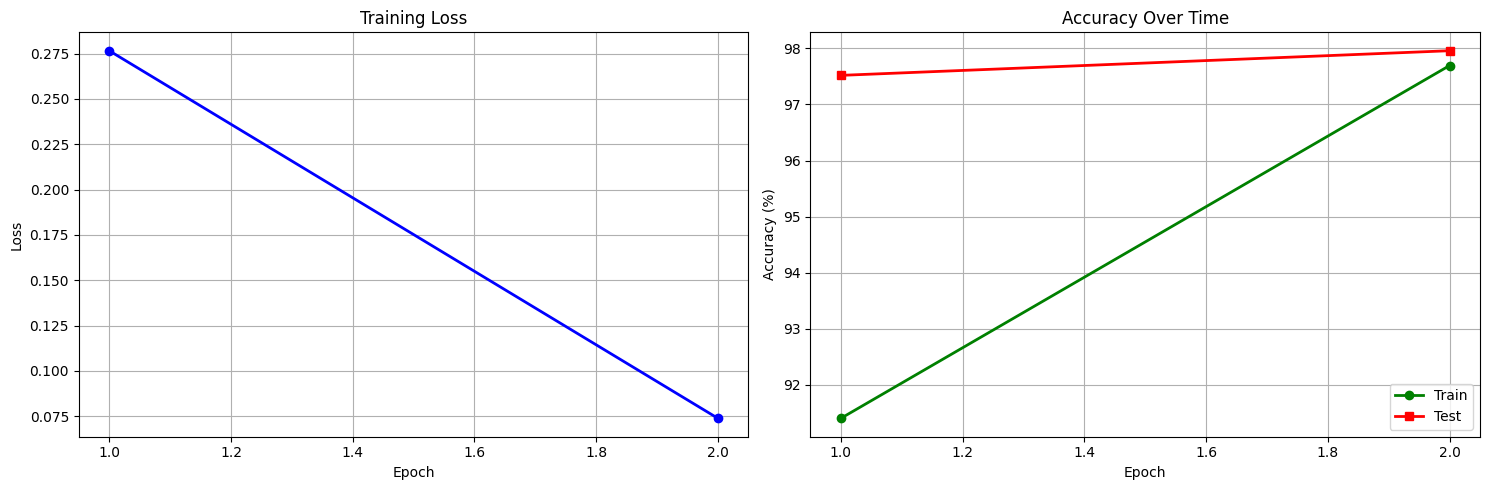

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(1, num_epochs+1), train_losses, 'b-o', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

ax2.plot(range(1, num_epochs+1), train_accuracies, 'g-o', label='Train', linewidth=2)
ax2.plot(range(1, num_epochs+1), test_accuracies, 'r-s', label='Test', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy Over Time')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 🔮 Step 7: Test Predictions

In [ ]:
# Prepare lists to store results
test_images = []
test_labels = []
predictions = []

model.eval()  # Tell model we are testing (not training)

# Test on 18 images
print("🔍 Making predictions on 18 test images...\n")

for i in range(18):
    # Step 1: Get one test image
    image, true_label = test_dataset[i]

    # Step 2: Prepare image for model
    image_for_model = image.unsqueeze(0).to(device)  # Prepare format and send to GPU

    # Step 3: Ask model to predict
    with torch.no_grad():  # Don't calculate gradients (faster)
        output = model(image_for_model)
        predicted_number = output.argmax().item()  # Get the number with highest score

    # Step 4: Save results
    test_images.append(image)
    test_labels.append(true_label)
    predictions.append(predicted_number)

# Visualize the results
fig, axes = plt.subplots(3, 6, figsize=(18, 10))

for i in range(18):
    ax = axes.flat[i]

    # Show the digit image
    ax.imshow(test_images[i].squeeze(), cmap='gray')

    # Check if prediction is correct
    true_number = test_labels[i]
    predicted_number = predictions[i]
    is_correct = (predicted_number == true_number)

    # Color: Green if correct, Red if wrong
    if is_correct:
        color = 'green'
    else:
        color = 'red'

    # Add title showing true label and prediction
    ax.set_title(f"True: {true_number}\nPredicted: {predicted_number}",
                 color=color, fontsize=11, fontweight='bold')
    ax.axis('off')

plt.suptitle('🔮 What the Model Predicted (Green=✓ Correct, Red=✗ Wrong)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Count how many were correct
correct_count = 0
for i in range(18):
    if predictions[i] == test_labels[i]:
        correct_count = correct_count + 1

print(f"✅ Got {correct_count} out of 18 correct!")
print(f"📊 Accuracy: {correct_count}/18 = {correct_count*100//18}%")

## 🔬 Step 8: Visualize Feature Maps

### 🎯 What This Does - Quick Explanation

**Shows what the neural network "sees" at each layer**

---

### 📸 The Visualization

**Original Image** (28×28)
- Your input handwritten digit

**Conv1 Features** (6 filters)
- Detects **simple patterns**: edges, lines, curves
- Each of the 6 filters looks for different basic features

**Conv2 Features** (16 filters)
- Detects **complex patterns**: corners, shapes, digit parts
- Combines Conv1 features into more meaningful structures

---

### 💡 Key Insight

**Brighter areas = Feature detected!**
- White/Yellow = High activation (filter found its pattern)
- Dark/Blue = Low activation (pattern not present)

Different filters activate for different parts of the digit → that's how the network recognizes numbers!

---

### 🧪 What You'll See

```
Input: "7"
├─ Conv1-Filter1: Detects vertical line (right side lights up)
├─ Conv1-Filter2: Detects horizontal line (top lights up)
├─ Conv1-Filter3: Detects diagonal edge
└─ ... etc

Conv2 combines these → recognizes "this is a 7"


**Run the cell multiple times** to see how different digits activate different filters!


In [ ]:
def visualize_feature_maps(model, image, true_label, device):
    model.eval()
    conv1_output = None
    conv2_output = None

    def hook_conv1(module, input, output):
        nonlocal conv1_output
        conv1_output = output

    def hook_conv2(module, input, output):
        nonlocal conv2_output
        conv2_output = output

    hook1 = model.conv1.register_forward_hook(hook_conv1)
    hook2 = model.conv2.register_forward_hook(hook_conv2)

    with torch.no_grad():
        image_gpu = image.unsqueeze(0).to(device)
        output = model(image_gpu)
        _, predicted = torch.max(output, 1)

    hook1.remove()
    hook2.remove()

    conv1_output = conv1_output.cpu().squeeze()
    conv2_output = conv2_output.cpu().squeeze()

    fig = plt.figure(figsize=(20, 10))

    ax = plt.subplot(3, 8, 1)
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'Original\nTrue: {true_label}\nPred: {predicted.item()}', fontsize=12, fontweight='bold')
    ax.axis('off')

    for i in range(6):
        ax = plt.subplot(3, 8, i + 3)
        ax.imshow(conv1_output[i], cmap='viridis')
        ax.set_title(f'Conv1-F{i+1}', fontsize=10)
        ax.axis('off')

    for i in range(16):
        ax = plt.subplot(3, 8, i + 9)
        ax.imshow(conv2_output[i], cmap='viridis')
        ax.set_title(f'Conv2-F{i+1}', fontsize=9)
        ax.axis('off')

    plt.suptitle('Feature Maps - What Each Layer Sees', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"Conv1 output: {conv1_output.shape}")
    print(f"Conv2 output: {conv2_output.shape}")

test_idx = np.random.randint(0, len(test_dataset))
test_image, test_label = test_dataset[test_idx]
print(f"Visualizing image #{test_idx}\n")
visualize_feature_maps(model, test_image, test_label, device)

## 🌡️ Step 9: Activation Heatmap

In [ ]:
def visualize_heatmap(model, image, true_label, device):
    model.eval()
    conv1_output = None

    def hook(module, input, output):
        nonlocal conv1_output
        conv1_output = output

    h = model.conv1.register_forward_hook(hook)

    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        _, predicted = torch.max(output, 1)

    h.remove()
    conv1_output = conv1_output.cpu().squeeze()
    heatmap = torch.mean(conv1_output, dim=0)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap_resized = torch.nn.functional.interpolate(
        heatmap.unsqueeze(0).unsqueeze(0), size=(28, 28), mode='bilinear'
    ).squeeze()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image.squeeze(), cmap='gray')
    axes[0].set_title(f'Original\nTrue: {true_label}, Pred: {predicted.item()}', fontsize=12)
    axes[0].axis('off')

    im = axes[1].imshow(heatmap_resized, cmap='jet')
    axes[1].set_title('Activation Heatmap', fontsize=12)
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1])

    axes[2].imshow(image.squeeze(), cmap='gray', alpha=0.6)
    axes[2].imshow(heatmap_resized, cmap='jet', alpha=0.4)
    axes[2].set_title('Overlay', fontsize=12)
    axes[2].axis('off')

    plt.suptitle('Activation Heatmap - Where Is The Network Looking?', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

test_idx = np.random.randint(0, len(test_dataset))
test_image, test_label = test_dataset[test_idx]
visualize_heatmap(model, test_image, test_label, device)

## 💾 Step 10: Save Model

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'final_accuracy': test_accuracies[-1]
}, 'lenet5_mnist.pth')

print("✅ Model saved as lenet5_mnist.pth")
print(f"📊 Final accuracy: {test_accuracies[-1]:.2f}%")

## 🎉 Summary

Congratulations! You have:
- ✅ Built and trained LeNet-5 on MNIST
- ✅ Visualized training progress
- ✅ Explored feature maps and activations
- ✅ Saved the trained model

**Experiment ideas:**
- Try different learning rates
- Add dropout layers
- Train for more epochs
- Test on your own handwritten digits!